# **1. Importing Necessary Libraries**

In [ ]:
!pip install pyngrok flask_ngrok

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from flask import Flask, request, jsonify
from pyngrok import ngrok
from flask_ngrok import run_with_ngrok

# **2. Load the Dataset**

In [5]:
# Load the dataset (adjust the file path based on Colab)
file_path = "/content/WeatherEvents_Jan2016-Dec2022.csv"
df = pd.read_csv(file_path)

# Display the first few rows
df.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode
0,W-1,Snow,Light,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
1,W-2,Snow,Light,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
2,W-3,Snow,Light,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
3,W-4,Snow,Light,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0
4,W-5,Snow,Light,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,US/Mountain,K04V,38.0972,-106.1689,Saguache,Saguache,CO,81149.0


# **3. Preprocessing: Convert Time Columns to Datetime Format**


In [7]:
df["StartTime(UTC)"] = pd.to_datetime(df["StartTime(UTC)"], errors="coerce")
df["EndTime(UTC)"] = pd.to_datetime(df["EndTime(UTC)"], errors="coerce")

# **4. Feature Engineering**

In [15]:
df["EventDuration"] = (df["EndTime(UTC)"] - df["StartTime(UTC)"]).dt.total_seconds() / 60
df["Month"] = df["StartTime(UTC)"].dt.month
df["Hour"] = df["StartTime(UTC)"].dt.hour
df["DayOfWeek"] = df["StartTime(UTC)"].dt.dayofweek

df.head()  # Check the new features

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),Precipitation(in),TimeZone,AirportCode,LocationLat,LocationLng,City,County,State,ZipCode,EventDuration,Month,Hour,DayOfWeek
0,0,5,1,2016-01-06 23:14:00,2016-01-07 00:34:00,0.00,2,0,38.0972,-106.1689,383,319,4,81149.0,80.0,1,23,2
1,1052210,5,1,2016-01-07 04:14:00,2016-01-07 04:54:00,0.00,2,0,38.0972,-106.1689,383,319,4,81149.0,40.0,1,4,3
2,1411180,5,1,2016-01-07 05:54:00,2016-01-07 15:34:00,0.03,2,0,38.0972,-106.1689,383,319,4,81149.0,580.0,1,5,3
3,1516451,5,1,2016-01-08 05:34:00,2016-01-08 05:54:00,0.00,2,0,38.0972,-106.1689,383,319,4,81149.0,20.0,1,5,4
4,1622441,5,1,2016-01-08 13:54:00,2016-01-08 15:54:00,0.00,2,0,38.0972,-106.1689,383,319,4,81149.0,120.0,1,13,4


# **5. Encode Categorical Features**

In [16]:
label_encoders = {}
categorical_cols = ["Type", "TimeZone", "AirportCode", "City", "County", "State", "Severity"]

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# **6. Data Visualization**


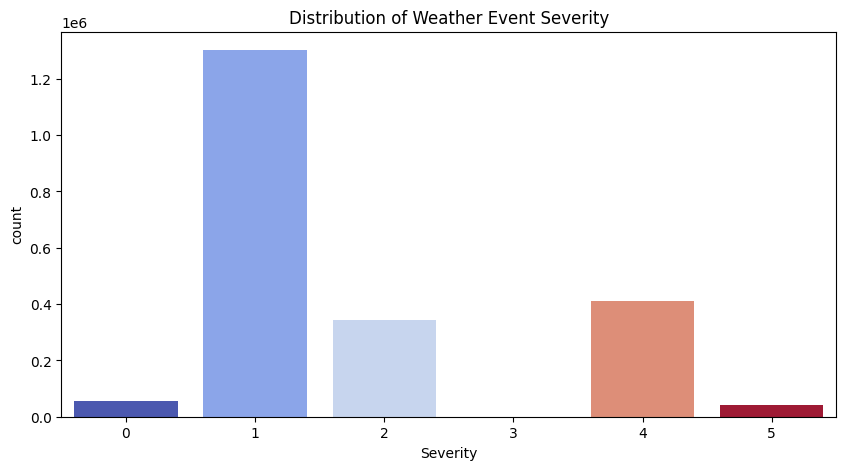

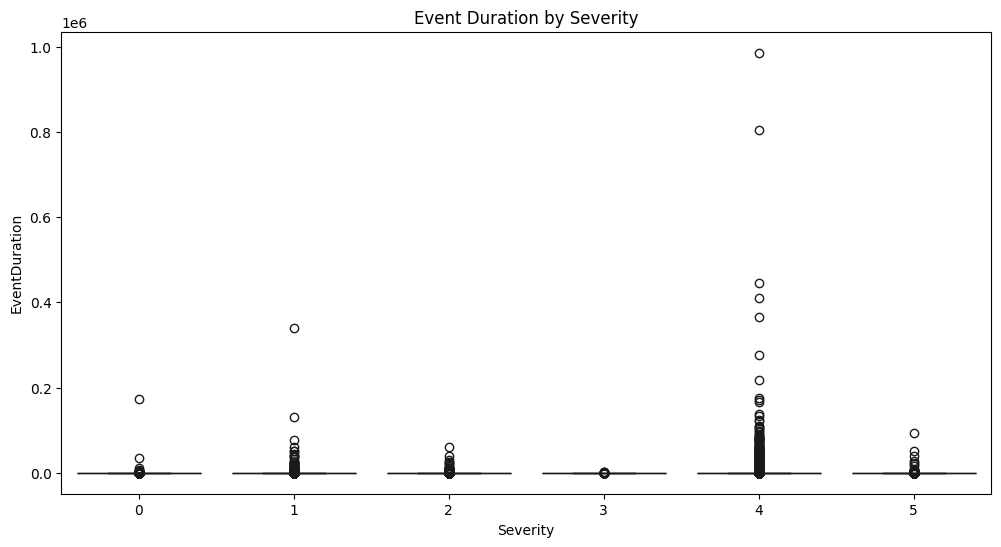

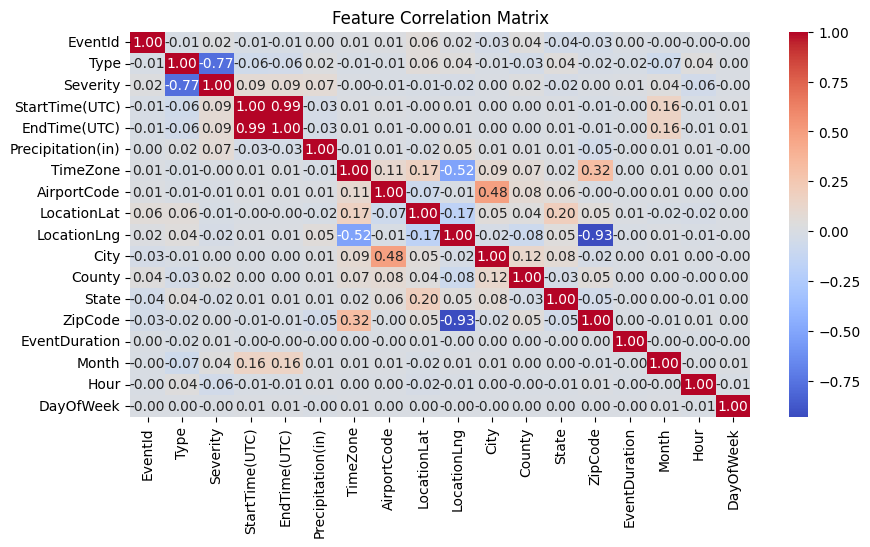

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x="Severity", data=df, hue="Severity", palette="coolwarm", legend=False)
plt.title("Distribution of Weather Event Severity")
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Severity", y="EventDuration", data=df, hue="Severity", palette="viridis", legend=False)
plt.title("Event Duration by Severity")
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


# **7. Select Features & Target Variable**

In [18]:
features = ["Precipitation(in)", "EventDuration", "Month", "Hour", "DayOfWeek", "Type"]
target = "Severity"

X = df[features]
y = df[target]

# **8. Data Normalization**

In [20]:
scaler = StandardScaler()
X.loc[:, ["Precipitation(in)", "EventDuration"]] = scaler.fit_transform(X[["Precipitation(in)", "EventDuration"]])

# **9. Splitting Data into Training & Test Sets**

In [25]:
df_sample = df.sample(frac=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df_sample[features], df_sample[target], test_size=0.2, random_state=42)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **10. Train & Tune Random Forest Model**



In [27]:
param_grid_rf = {
    "n_estimators": [50, 100],
    "max_depth": [None, 10],
    "min_samples_split": [2],
    "min_samples_leaf": [1]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=2, scoring="accuracy", n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Best Random Forest model
best_rf = grid_search_rf.best_estimator_

# **11. Train & Tune XGBoost Model**

In [30]:
param_grid_xgb = {
    "n_estimators": [50, 100],
    "learning_rate": [0.1],
    "max_depth": [3],
    "subsample": [0.8]
}
xgb = XGBClassifier(random_state=42)
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=3, scoring="accuracy", n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Best XGBoost model
best_xgb = grid_search_xgb.best_estimator_

# **12. Model Evaluation**

Evaluating Random Forest:
Random Forest Accuracy: 0.9142

              precision    recall  f1-score   support

           0       0.80      0.75      0.77      1082
           1       0.98      0.98      0.98     26110
           2       0.78      0.64      0.71      6837
           3       1.00      0.71      0.83        14
           4       0.80      0.93      0.86      8116
           5       1.00      1.00      1.00       824

    accuracy                           0.91     42983
   macro avg       0.90      0.84      0.86     42983
weighted avg       0.91      0.91      0.91     42983



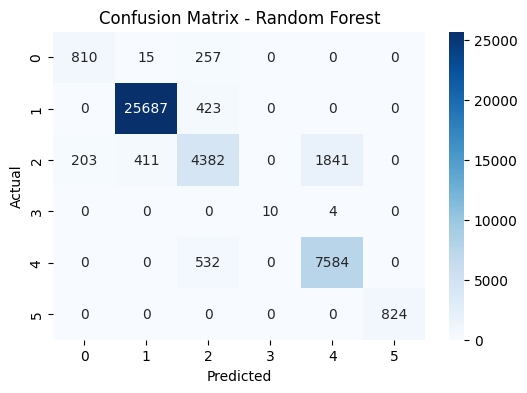


Evaluating XGBoost:
XGBoost Accuracy: 0.9140

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1082
           1       0.98      0.98      0.98     26110
           2       0.79      0.63      0.70      6837
           3       1.00      1.00      1.00        14
           4       0.80      0.94      0.87      8116
           5       1.00      1.00      1.00       824

    accuracy                           0.91     42983
   macro avg       0.89      0.89      0.89     42983
weighted avg       0.91      0.91      0.91     42983



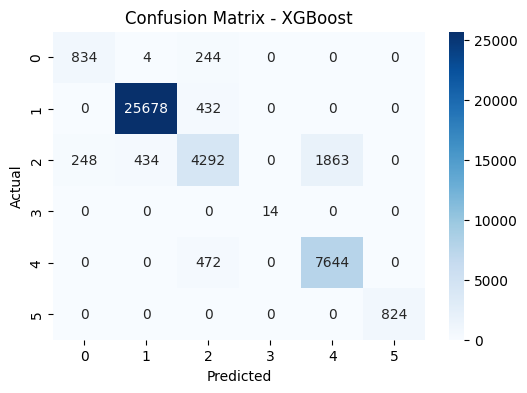

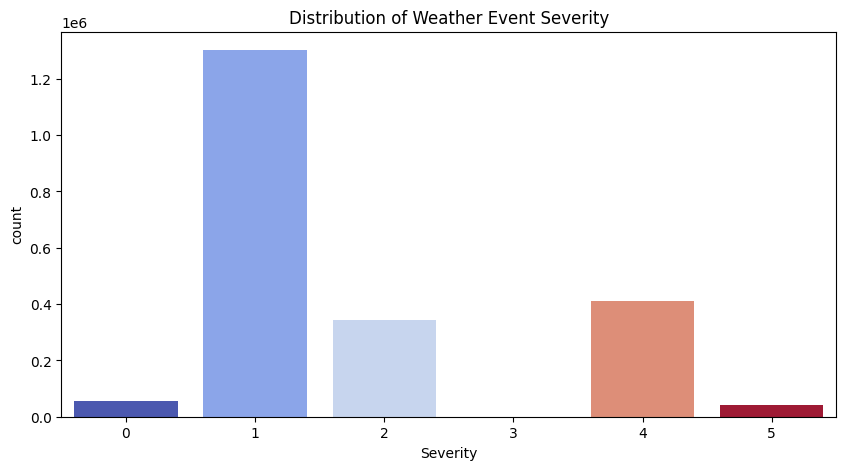

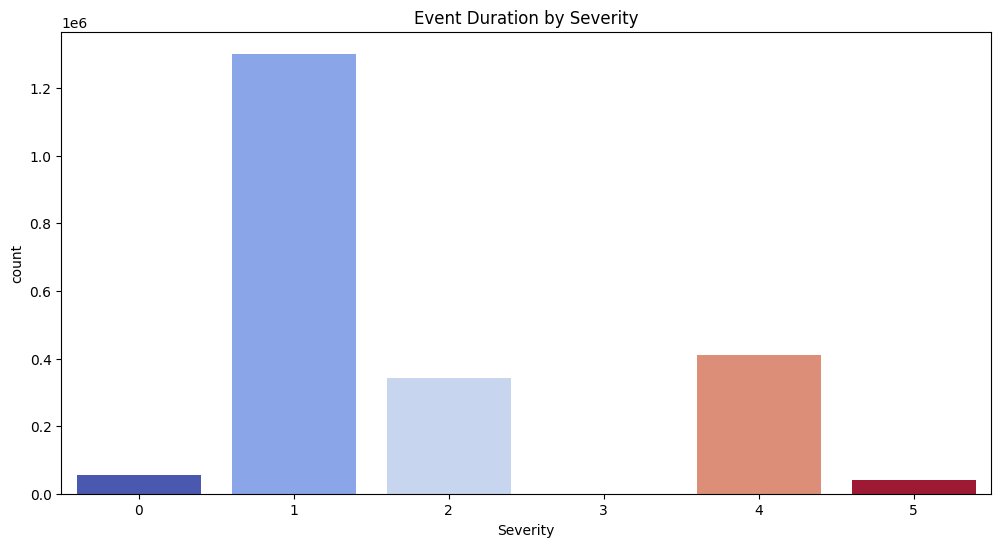

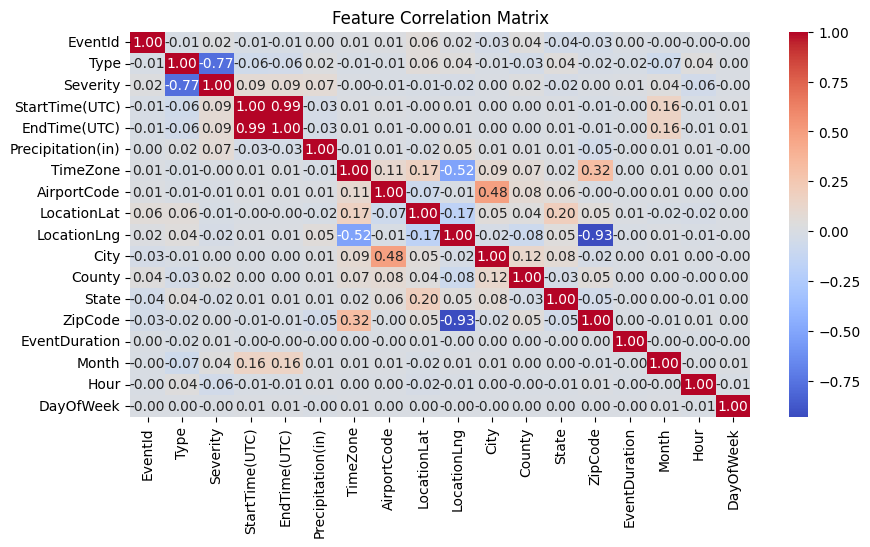

In [39]:
# Step 12: Model Evaluation & Visualizations

# Function to evaluate model and plot confusion matrix
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {acc:.4f}\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return acc

# Evaluate Random Forest
print("Evaluating Random Forest:")
rf_acc = evaluate_model(best_rf, X_test, y_test, "Random Forest")

# Evaluate XGBoost
print("\nEvaluating XGBoost:")
xgb_acc = evaluate_model(best_xgb, X_test, y_test, "XGBoost")

# Additional Visualization
plt.figure(figsize=(10, 5))
sns.countplot(x="Severity", data=df, palette="coolwarm", hue="Severity", dodge=False)
plt.title("Distribution of Weather Event Severity")
plt.legend([], [], frameon=False)  # Hide legend
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x="Severity", data=df, palette="coolwarm", hue="Severity", legend=False)
plt.title("Event Duration by Severity")
plt.show()

plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()


# **13. Select the Best Model**

In [69]:

# Compare model performance
print("\nModel Performance Comparison:")
print(f"Random Forest Accuracy: {rf_acc:.4f}")
print(f"XGBoost Accuracy: {xgb_acc:.4f}")

# Select the best model
if xgb_acc > rf_acc:
    final_model = best_xgb
    print("\nXGBoost performed better and is selected as the final model!")
else:
    final_model = best_rf
    print("\nRandom Forest performed better and is selected as the final model!")

# Print the best model details
print(f"\nFinal Model Selected: {final_model.__class__.__name__}")
print(f"Best Accuracy Achieved: {max(rf_acc, xgb_acc):.4f}")



Model Performance Comparison:
Random Forest Accuracy: 0.9142
XGBoost Accuracy: 0.9140

Random Forest performed better and is selected as the final model!

Final Model Selected: RandomForestClassifier
Best Accuracy Achieved: 0.9142


# **14. Save the Model**

In [40]:
with open("weather_model.pkl", "wb") as model_file:
    pickle.dump(final_model, model_file)

# **15. Deploy Model Using Gradio**

In [68]:
import gradio as gr
import pickle
import numpy as np

# Load the model
with open("weather_model.pkl", "rb") as model_file:
    model = pickle.load(model_file)

# Define categories
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
event_types = ["Rain", "Snow", "Thunderstorm", "Fog", "Clear", "Cloudy", "Other"]  # Add actual categories from your dataset

# Severity level definitions (for display)
severity_levels = """
**Severity Levels:**
🟢 1 - Low: Minimal impact
🟡 2 - Moderate: Some disruptions
🟠 3 - High: Significant disruptions
🔴 4 - Severe: Dangerous conditions
"""

with gr.Blocks() as demo:
    gr.Markdown(severity_levels)  # Display severity levels at the top

# Gradio Interface with Dropdowns
interface = gr.Interface(
    fn=predict_weather,
    inputs=[
        gr.Number(label="Precipitation (in)"),
        gr.Number(label="Event Duration (min)"),
        gr.Dropdown(choices=months, label="Month"),
        gr.Slider(minimum=0, maximum=23, step=1, label="Hour of Day"),
        gr.Dropdown(choices=days_of_week, label="Day of the Week"),
        gr.Dropdown(choices=event_types, label="Event Type"),
    ],
    outputs="text",
    title="Weather Severity Predictor",
    description="Enter weather event details to predict severity.\n \n🟢 1 - Low: Minimal impact  \n🟡 2 - Moderate: Some disruptions  \n🟠 3 - High: Significant disruptions  \n🔴 4 - Severe: Dangerous conditions ",
)

# Display severity levels below the interface
interface.launch(share=True)
print(severity_levels)  # Just displays the text output in the terminal/logs


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4834801c7a91f97015.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



**Severity Levels:**
🟢 1 - Low: Minimal impact  
🟡 2 - Moderate: Some disruptions  
🟠 3 - High: Significant disruptions  
🔴 4 - Severe: Dangerous conditions  

